# Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import time
from joblib import dump, load
import datetime as dt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_curve, auc, precision_recall_curve, \
ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

plt.rcParams.update({'font.size':14})

In [2]:
def save_model(model, model_name: str):
    
    save_path_suffix = dt.datetime.now().strftime('%m-%d-%Y-%H-%M-%S') + '.joblib' #add current time to fname
    
    dump(model, 'models/' + model_name + save_path_suffix);

In [19]:
def prep_data(df, feats_to_drop=[]) -> list:
    
    """
    Preps the data returning a list of [dataframe, num_feats, cat_feats]
    """
    
    df_out = df.copy()
    
    # open dictionary of ALL features and feature types
    with open('cat_vs_num.json', 'r') as f:
        cat_vs_num = json.load(f)
        num_feats, cat_feats = cat_vs_num['num_feat_names'], cat_vs_num['cat_feat_names']
        
    # fix nans in gender
    df_out['CODE_GENDER'] = df_out['CODE_GENDER'].apply(lambda x: np.nan if x=='XNA' else x)
    
    # fix days employed
    df_out['DAYS_EMPLOYED'] = df_out.DAYS_EMPLOYED.apply(lambda x: x if x!=x else -x if x<1 else np.nan)
    
    # fix age
    df_out['AGE'] = df_out['DAYS_BIRTH'].apply(lambda x: -x/365)
    df_out.drop('DAYS_BIRTH', axis=1, inplace=True)
    num_feats.append('AGE')
    
    # remove children from family members
    df_out['CNT_NON_CHILD_FAM_MEMBERS'] = df_out['CNT_FAM_MEMBERS'] - df_out['CNT_CHILDREN']
    df_out.drop('CNT_FAM_MEMBERS', axis=1, inplace=True)
    num_feats.append('CNT_NON_CHILD_FAM_MEMBERS')
    
    # replace credit with credit/annuity
    df_out['CREDIT_PER_ANNUITY'] = df_out['AMT_CREDIT']/df_out['AMT_ANNUITY']
    df_out.drop('AMT_CREDIT', axis=1, inplace=True)
    num_feats.append('CREDIT_PER_ANNUITY')
    
    # replace annuity with annuity/goods price
    df_out['ANNUITY_PER_GOODS_PRICE'] = df_out['AMT_ANNUITY']/df_out['AMT_GOODS_PRICE']
    df_out.drop('AMT_ANNUITY', axis=1, inplace=True)
    num_feats.append('ANNUITY_PER_GOODS_PRICE')
    
# ------------------------------------------------------------------------------------- #

    # drop unwanted features from df_out   
    feats_to_drop_0 = ['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    
    df_out.drop(feats_to_drop_0 + feats_to_drop, axis=1, inplace=True, errors='ignore')
    
    # drop unwanted features from num. and cat. feature lists
    num_feats_to_drop, cat_feats_to_drop = [], []
    
    for feat in num_feats:
        if feat not in df_out.columns:
            num_feats_to_drop.append(feat)
            
    for feat in cat_feats:
        if feat not in df_out.columns:
            cat_feats_to_drop.append(feat)
            
    for feat in num_feats_to_drop:
        num_feats.remove(feat)
        
    for feat in cat_feats_to_drop:
        cat_feats.remove(feat)
        
    #reorder dataframe to match order of num_feats and cat_feats        
    df_out = df_out.loc[:,num_feats+cat_feats]
        
    print(f'# of Total Features: {len(num_feats)+len(cat_feats)}')
    print(f'# of Numeric Features: {len(num_feats)}')
    print(f'# of Categorical Features: {len(cat_feats)}')
    
    return df_out, num_feats, cat_feats

# Load and Split Data

In [4]:
pd.options.display.max_colwidth = 200
df_desc = pd.read_csv('columns_description.csv')
df_desc[df_desc.Table=='application_data'][['Row', 'Description']].head(5)

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car


In [5]:
descriptions = dict(zip(df_desc.Row, df_desc.Description))

In [6]:
df = pd.read_csv('application_data.csv')
print(df.shape)
df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


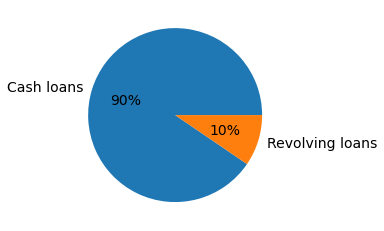

In [7]:
y = df.NAME_CONTRACT_TYPE.value_counts(normalize=True)
# plt.bar(x=y.index, height=y.values)
plt.pie(y, labels=y.index, autopct='%1.0f%%');
# plt.savefig('loan_type_pie_chart.png', dpi=300);

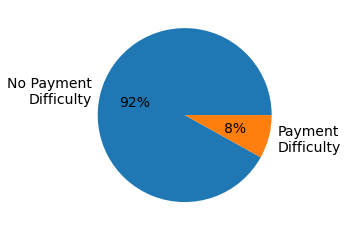

In [8]:
y = df.TARGET.value_counts(normalize=True)
# plt.bar(x=y.index, height=y.values)
plt.pie(y, labels=['No Payment\nDifficulty', 'Payment\nDifficulty'], autopct='%1.0f%%');
# plt.savefig('target_distribution_pie_chart.png', dpi=300);

In [9]:
descriptions['AMT_APPLICATION']

'For how much credit did client ask on the previous application'

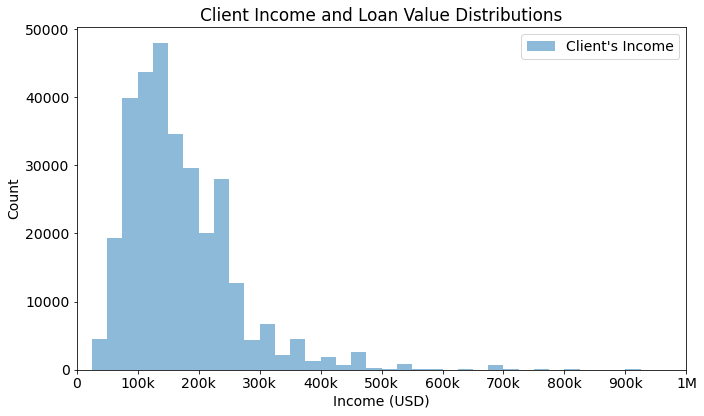

In [10]:
plt.figure(figsize=(10,6))
plt.hist(df.AMT_INCOME_TOTAL, range=[0,1_000_000], alpha=0.5, bins=40, label="Client's Income");
# plt.hist(df.AMT_CREDIT, range=[0,1_000_000], alpha=0.5, bins=40, label ="Value of Previous Loan");
plt.xlabel('Income (USD)')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(0, 10**6+100000, 100000), labels=['0', '100k', '200k', '300k', '400k', '500k',
                                                            '600k', '700k', '800k', '900k', '1M'])
plt.xlim(0, 1_000_000)
plt.title('Client Income and Loan Value Distributions')
plt.legend()

plt.tight_layout()
# plt.savefig('income_hist_2.png', dpi=300);

In [11]:
pd.options.display.max_rows=122
df.isna().sum().apply(lambda x: x/307551).sort_values(ascending=False)

COMMONAREA_MEDI                 0.698632
COMMONAREA_AVG                  0.698632
COMMONAREA_MODE                 0.698632
NONLIVINGAPARTMENTS_MODE        0.694239
NONLIVINGAPARTMENTS_AVG         0.694239
NONLIVINGAPARTMENTS_MEDI        0.694239
FONDKAPREMONT_MODE              0.683773
LIVINGAPARTMENTS_MODE           0.683461
LIVINGAPARTMENTS_AVG            0.683461
LIVINGAPARTMENTS_MEDI           0.683461
FLOORSMIN_AVG                   0.678398
FLOORSMIN_MODE                  0.678398
FLOORSMIN_MEDI                  0.678398
YEARS_BUILD_MEDI                0.664891
YEARS_BUILD_MODE                0.664891
YEARS_BUILD_AVG                 0.664891
OWN_CAR_AGE                     0.659822
LANDAREA_MEDI                   0.593690
LANDAREA_MODE                   0.593690
LANDAREA_AVG                    0.593690
BASEMENTAREA_MEDI               0.585083
BASEMENTAREA_AVG                0.585083
BASEMENTAREA_MODE               0.585083
EXT_SOURCE_1                    0.563737
NONLIVINGAREA_MO

In [12]:
pd.options.display.max_columns=6
rename_dict = {'TARGET': 'Payment Difficulties', 'NAME_CONTRACT_TYPE': 'Contract Type',
               'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Owns Car', 'FLAG_OWN_REALTY': 'Owns Home',
              'CNT_CHILDREN': 'Num. Children', 'AMT_INCOME_TOTAL': 'Income',
               'AMT_CREDIT': 'Credit of Last Loan'}
cols = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
df.loc[:,cols].rename(rename_dict, axis=1).head()

,Payment Difficulties,Contract Type,Gender,...,Owns Home,Income,Credit of Last Loan
0,1,Cash loans,M,...,Y,202500.0,406597.5
1,0,Cash loans,F,...,N,270000.0,1293502.5
2,0,Revolving loans,M,...,Y,67500.0,135000.0
3,0,Cash loans,F,...,Y,135000.0,312682.5
4,0,Cash loans,M,...,Y,121500.0,513000.0


In [14]:
df['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

feats_to_drop = ['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

x_train, x_test, y_train, y_test = train_test_split(df.drop(feats_to_drop+['TARGET'], axis=1), df.TARGET, 
                                                    test_size=0.1, stratify=df.TARGET, random_state=17)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/9, stratify=y_train,
                                                      random_state=17)

print(f'{x_train.shape=}, {y_train.shape=}')
print(f'{x_valid.shape=}, {y_valid.shape=}')
print(f'{x_test.shape=}, {y_test.shape=}')

x_train.shape=(246008, 117), y_train.shape=(246008,)
x_valid.shape=(30751, 117), y_valid.shape=(30751,)
x_test.shape=(30752, 117), y_test.shape=(30752,)


# Data Cleaning

## One Time Exploration (No Need to Repeat)

In [8]:
# Sus out categorical features
# pd.options.display.max_rows = 123
# df.nunique().sort_values()

In [9]:
# used this to determine which features are categorical and which are numeric
# from IPython.display import clear_output
# uniques = df.nunique().sort_values()

# cat_feats = []
# num_feats = []

# for column in uniques.index:
#     print(column+f': {uniques.loc[column]}\n')
#     print(df_desc[df_desc.Row==column].Description.iloc[0])
#     print()
#     print(df[column].value_counts())
#     input_ = input('press q to quit')
#     if input_=='q':
#         break
#     elif input_=='n':
#         num_feats.append(column)
#         clear_output(wait=False)
#     elif input_=='c':
#         cat_feats.append(column)
#         clear_output(wait=False)
#     else:
#         clear_output(wait=False)

In [10]:
# len(cat_vs_num['num_feat_names'])+len(cat_vs_num['cat_feat_names'])

# num_feats.remove('SK_ID_CURR')
# cat_feats.remove('TARGET')

# print('TARGET' in cat_vs_num['cat_feat_names'])
# print('SK_ID_CURR' in cat_vs_num['num_feat_names'])

In [11]:
# # save categorical and numeric feature names
# import json

# cat_vs_num = {'cat_feat_names': cat_feats, 'num_feat_names': num_feats}
# with open('cat_vs_num.json', 'w') as f:
#     json.dump(cat_vs_num, f)

In [12]:
# # examine number of na's by feature

# pd.options.display.max_rows=122
# print(len(x_train))
# x_train.isna().sum().sort_values(ascending=False)[:60]

## Data Cleaning Continued

In [138]:
# drop features with more than 25% nans (mostly info on home)
na_df = x_train.isna().sum()
feats_to_drop_nans = []
for feat in na_df.index:
    if na_df[feat]>len(x_train)/4:
        feats_to_drop_nans.append(feat)

In [139]:
collinear_feats_to_drop = [
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'REGION_RATING_CLIENT'
]

In [140]:
x_train_prepped, num_feats, cat_feats = prep_data(x_train, feats_to_drop=feats_to_drop_nans+collinear_feats_to_drop)
x_valid_prepped, num_feats, cat_feats = prep_data(x_valid, feats_to_drop=feats_to_drop_nans+collinear_feats_to_drop)
x_test_prepped, num_feats, cat_feats = prep_data(x_test, feats_to_drop=feats_to_drop_nans+collinear_feats_to_drop)

# of Total Features: 64
# of Numeric Features: 19
# of Categorical Features: 45
# of Total Features: 64
# of Numeric Features: 19
# of Categorical Features: 45
# of Total Features: 64
# of Numeric Features: 19
# of Categorical Features: 45


In [65]:
x_train_prepped_num, _, _ = prep_data(x_train, feats_to_drop=feats_to_drop_nans + collinear_feats_to_drop + cat_feats)
x_valid_prepped_num, _, _ = prep_data(x_valid, feats_to_drop=feats_to_drop_nans + collinear_feats_to_drop + cat_feats)
x_test_prepped_num, _, _ = prep_data(x_test, feats_to_drop=feats_to_drop_nans + collinear_feats_to_drop + cat_feats)

# of Total Features: 19
# of Numeric Features: 19
# of Categorical Features: 0
# of Total Features: 19
# of Numeric Features: 19
# of Categorical Features: 0
# of Total Features: 19
# of Numeric Features: 19
# of Categorical Features: 0


# Preprocessing

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('one_hot_encode', OneHotEncoder())
])


pipe = ColumnTransformer([
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

In [142]:
x_train_pp = pipe.fit_transform(x_train_prepped)
x_valid_pp = pipe.transform(x_valid_prepped)
x_test_pp = pipe.transform(x_test_prepped)

In [143]:
cat_feats_out = list(pipe.transformers_[1][1]['one_hot_encode'].get_feature_names_out(cat_feats))
feat_names = num_feats + cat_feats_out
print(f'Total Features after Encoding: {len(feat_names)}')

Total Features after Encoding: 217


In [207]:
x_train_pp_num = num_pipeline.fit_transform(x_train_prepped_num)
x_valid_pp_num = num_pipeline.transform(x_valid_prepped_num)
x_test_pp_num = num_pipeline.transform(x_test_prepped_num)

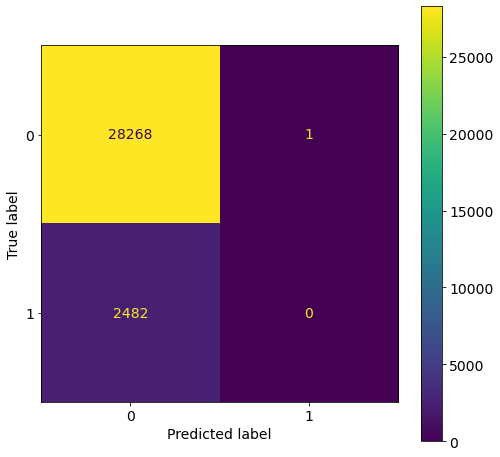

In [209]:
# start = time.time()
# lm_num_only = LogisticRegression(random_state=17, class_weight=None, warm_start=True, max_iter=100)
# lm_num_only.fit(x_train_pp_num, y_train)
# end = time.time()

# save_model(lm_num_only, 'lm_num_only')
# print(f'Model Trained in {end-start:.0f}s')

# score = lm_num_only.score(x_valid_pp_num, y_valid)
# print(f'Model score: {score}')
    
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(lm_num_only, x_valid_pp_num, y_valid, ax=ax1);

(0.0, 1.0)

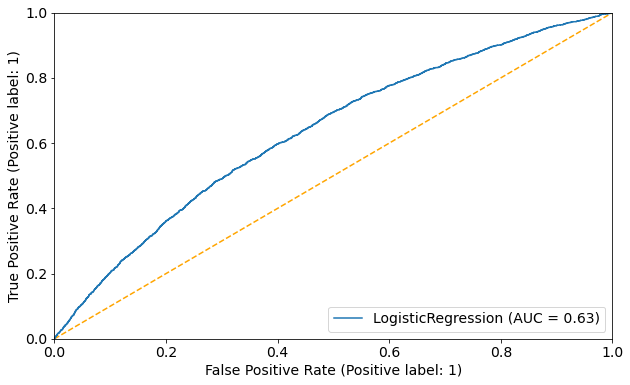

In [210]:
fig = plt.figure(figsize=(10,6))
ax = fig.subplots()
ax.plot([0,1], [0,1], linestyle='--', c='orange')

RocCurveDisplay.from_estimator(lm_num_only, x_valid_pp_num, y_valid, ax=ax);
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# Feature Engineering

In [183]:
train_data_pp = pd.DataFrame(x_train_pp)
train_data_pp.columns = feat_names
train_data_pp['TARGET'] = y_train
train_data_pp.head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,...,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
0,-0.070932,-0.058197,-0.15496,...,0.0,0.0,1.0
1,-0.070932,-0.058197,-0.15496,...,0.0,0.0,NaN
2,-0.070932,-0.058197,-0.15496,...,0.0,0.0,0.0
3,-0.070932,-0.058197,-0.15496,...,0.0,1.0,0.0
4,-0.070932,-0.058197,-0.15496,...,0.0,0.0,0.0


In [196]:
corr = train_data_pp.sample(50000, axis=0, random_state=17).corr()
corr.TARGET.sort_values(ascending=False)[:20]

TARGET                                 1.000000
NAME_INCOME_TYPE_Student               0.018503
NAME_CONTRACT_TYPE_Cash loans          0.014201
HOUR_APPR_PROCESS_START_23             0.013003
NAME_INCOME_TYPE_State servant         0.012673
FLAG_DOCUMENT_16_1                     0.011930
ORGANIZATION_TYPE_Medicine             0.011467
ORGANIZATION_TYPE_Telecom              0.011308
FLAG_OWN_CAR_N                         0.010915
ORGANIZATION_TYPE_Industry: type 2     0.010539
ORGANIZATION_TYPE_Culture              0.009532
WEEKDAY_APPR_PROCESS_START_SATURDAY    0.009250
ORGANIZATION_TYPE_University           0.009046
FLAG_DOCUMENT_2_1                      0.007964
ORGANIZATION_TYPE_Transport: type 4    0.007645
NAME_TYPE_SUITE_Children               0.007129
AMT_GOODS_PRICE                        0.006464
HOUR_APPR_PROCESS_START_6              0.006243
DAYS_LAST_PHONE_CHANGE                 0.005919
HOUR_APPR_PROCESS_START_11             0.005823
Name: TARGET, dtype: float64

In [111]:
# pd.options.display.max_columns=130
# pd.options.display.max_rows=130
# high_collinearity = x_train_prepped.corr()
# # high_collinearity

In [215]:
# corr_series = pd.Series(dtype='float64')
# for i, index in enumerate(high_collinearity.columns):
#     for column in high_collinearity.index[:i]:
# #         if high_collinearity.loc[index, column] != 0:
#         corr_series = corr_series.append(pd.Series(high_collinearity.loc[index, column], index=[index+' vs. '+column]))
# corr_series.sort_values(key=abs, ascending=False, inplace=True)
# corr_series[:17]

In [135]:
# temp = list(zip([x.split(' vs. ')[0] for x in corr_series.index.values[:26]], 
#     [x.split(' vs. ')[1] for x in corr_series.index.values[:26]]))
# temp = np.array(test)
# temp = test.flatten()

# uncomment this block to plot
# for i in range(0,int(len(temp)//2),2):
#     plt.scatter(x_train_prepped[temp[i]], x_train_prepped[temp[i+1]], alpha=0.4)
#     plt.xlabel(temp[i])
#     plt.ylabel(temp[i+1])
#     plt.show()

# moral of the story is that some features can be removed and annuity, credit, and goods price should be
# refactored into goods price, annuity/goods price, and credit/annuity.

In [136]:
# # analysis above led to this list of features to drop

# collinear_feats_to_drop = [
#     'OBS_60_CT_SOCIAL_CIRCLE',
#     'DEF_60_CNT_SOCIAL_CIRCLE',
#     'REGION_RATING_CLIENT'
# ]

In [132]:
descriptions['AMT_ANNUITY']

'Annuity of previous application'

In [81]:
x_train['REG_CITY_NOT_WORK_CITY'].value_counts()

0    189412
1     56596
Name: REG_CITY_NOT_WORK_CITY, dtype: int64

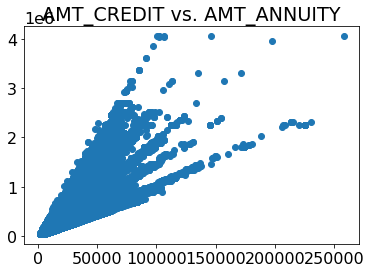

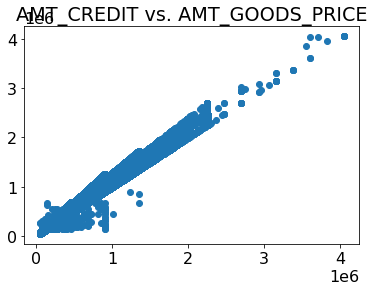

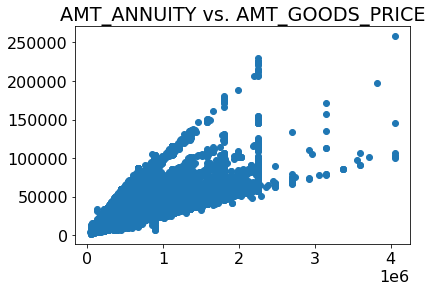

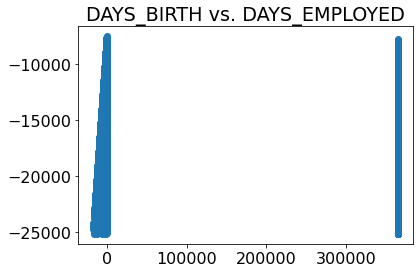

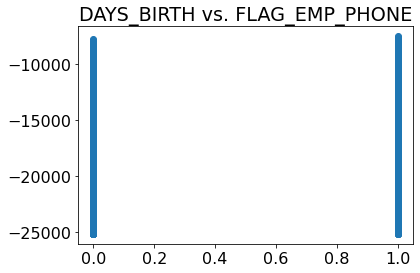

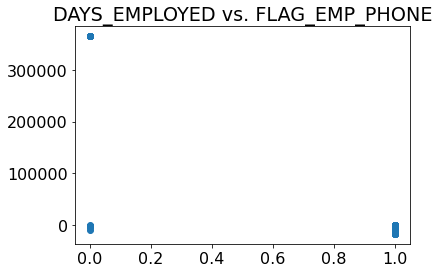

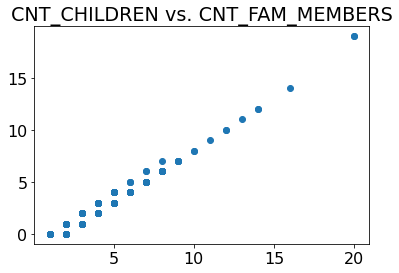

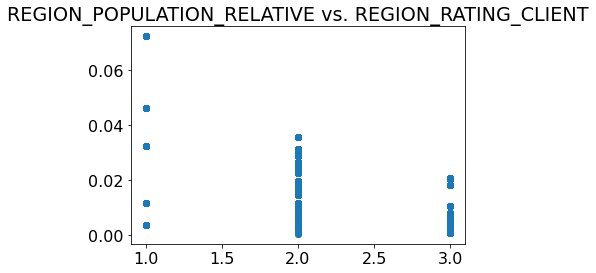

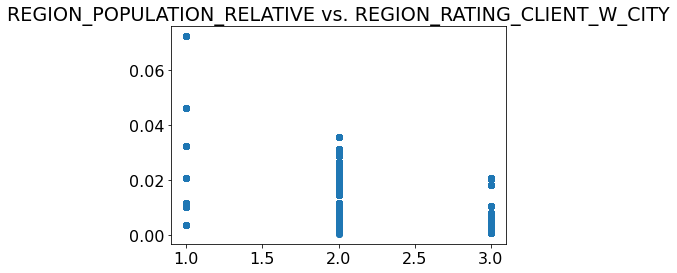

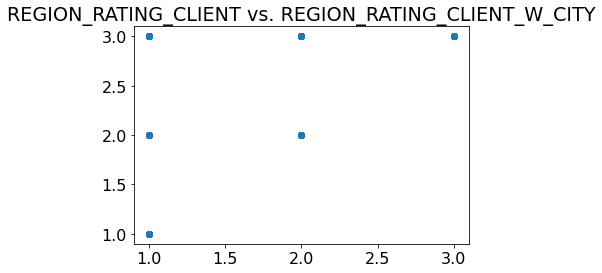

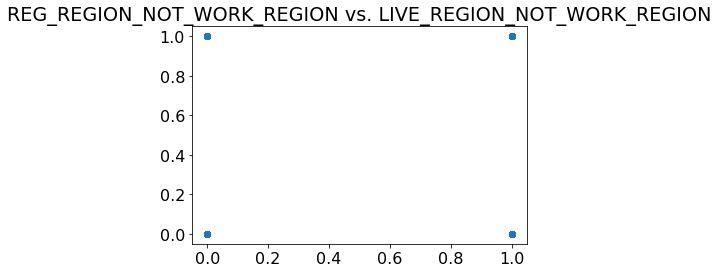

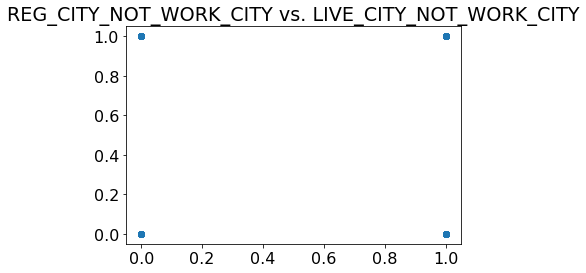

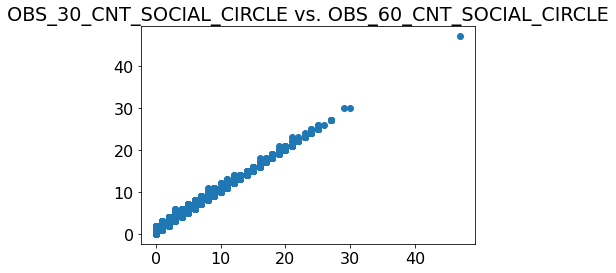

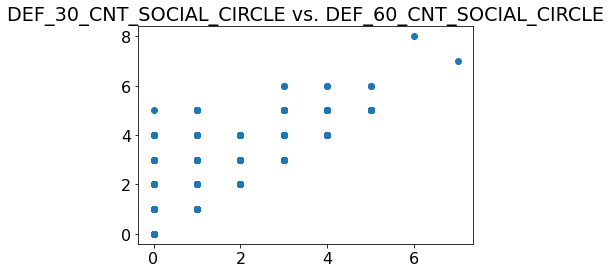

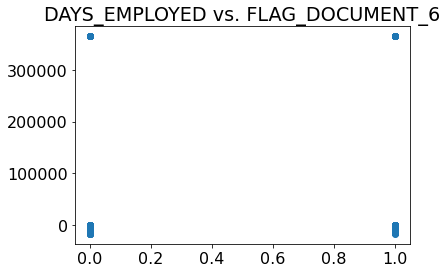

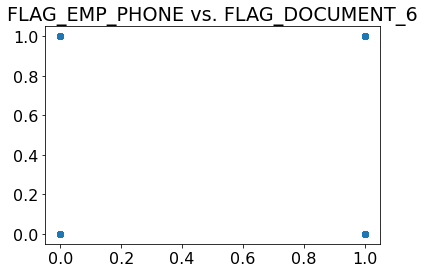

In [75]:
from time import sleep

sample = x_train.sample(1000, axis=0, random_state=17)
for i, feat in enumerate(high_collinearity.columns):
    for index in high_collinearity.index[:i]:
        if high_collinearity.loc[index, feat] != 0:
            plt.scatter(x_train[feat], x_train[index])
            plt.title(f'{index} vs. {feat}')
            plt.show()
            sleep(2)

(array([ 9940., 22070., 26001., 26742., 27603., 32191., 33409., 30702.,
        26435., 10915.]),
 array([-69.04383562, -64.19123288, -59.33863014, -54.4860274 ,
        -49.63342466, -44.78082192, -39.92821918, -35.07561644,
        -30.2230137 , -25.37041096, -20.51780822]),
 <BarContainer object of 10 artists>)

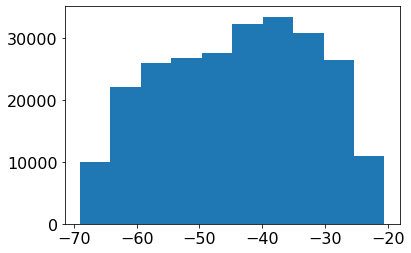

In [80]:
plt.hist(x_train.DAYS_BIRTH/365)

In [88]:
descriptions['DAYS_EMPLOYED']

'How many days before the application the person started current employment'

 365243    44213
-224         137
-200         129
-230         122
-212         122
           ...  
-8925          1
-12443         1
-10846         1
-6304          1
-12317         1
Name: DAYS_EMPLOYED, Length: 12059, dtype: int64


(array([1.06209e+05, 5.22910e+04, 2.25140e+04, 9.61500e+03, 5.44500e+03,
        2.80700e+03, 1.70400e+03, 8.88000e+02, 2.71000e+02, 5.10000e+01]),
 array([    0. ,  1758.3,  3516.6,  5274.9,  7033.2,  8791.5, 10549.8,
        12308.1, 14066.4, 15824.7, 17583. ]),
 <BarContainer object of 10 artists>)

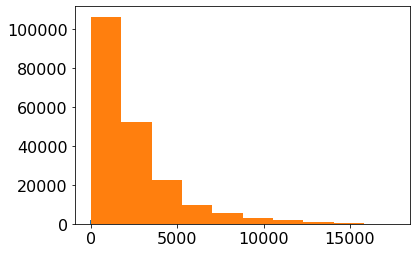

In [90]:
print(x_train.DAYS_EMPLOYED.value_counts())
plt.hist(x_train.DAYS_EMPLOYED[x_train.DAYS_EMPLOYED<365243]/365);
x_train['DAYS_EMPLOYED'] = x_train.DAYS_EMPLOYED.apply(
    lambda x: x if x!=x else -x if x<1 else np.nan)

plt.hist(x_train.DAYS_EMPLOYED)

In [199]:
def plot_features(feats: list):
    
    x = train_data_pp[feats]
    y = train_data_pp.TARGET
    
#     # only include features that are in x_train (remove categorical feats)
#     feats = set(feats)
#     feats = feats.intersection(set(x_train.columns))
    
    N = len(feats)
    feat_types = []
    for feat in feats:
        if feat in num_feats:
            feat_types.append('num')
        elif (feat in cat_feats_out) or (feat in cat_feats):
            feat_types.append('cat')
    
    fig = plt.figure(figsize=(15,4*(((N-1)//2)+1))) # gets taller every 2 add. features
    
    if N==1:
        ax = fig.subplots()
        ax.hist(x[y==0], density=True, alpha=0.5, label=feats[0]+' Neg.')
        ax.hist(x[y==1], density=True, alpha=0.5, label=feats[0]+' Pos.')
        ax.legend()
        ax.set_title(feats[0])
        
    else:
        axs = fig.subplots(nrows=(N-1)//2+1, ncols=2).flatten()
    
        for i, feat in enumerate(feats):
            axs[i].hist(x[y==0][feat], density=True, alpha=0.5, label=feat+' Neg.')
            axs[i].hist(x[y==1][feat], density=True, alpha=0.5, label=feat+' Pos.')
            axs[i].legend()
            axs[i].set_title(feat+': '+feat_types[i])

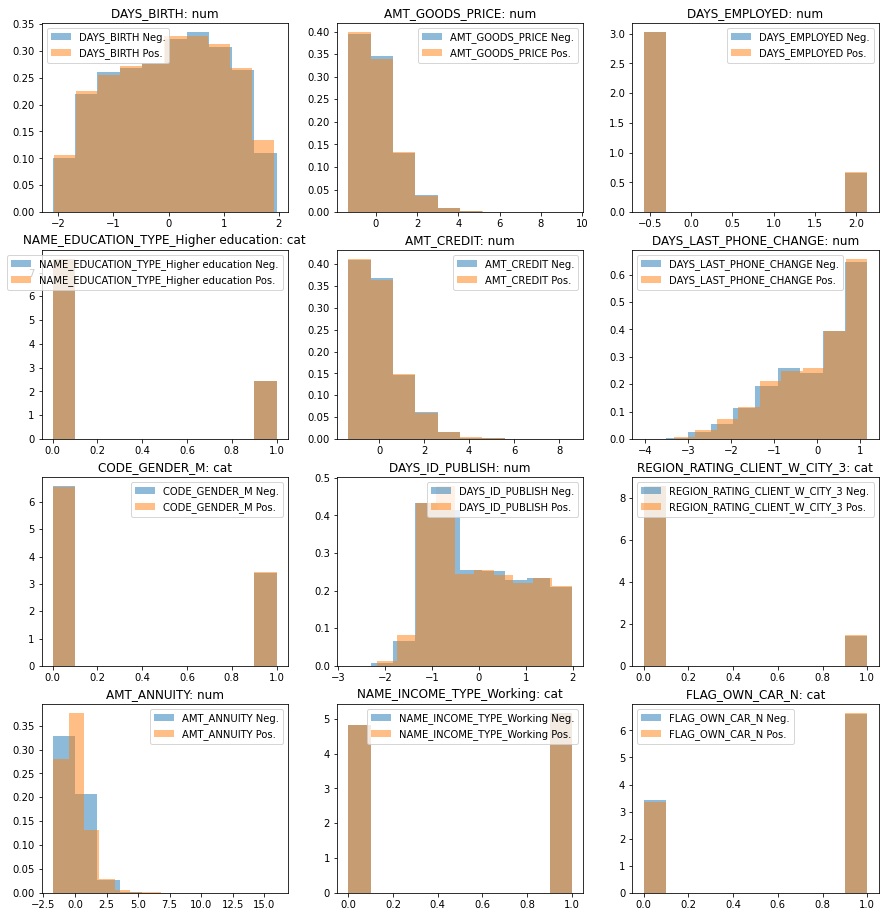

In [33]:
plot_features(forest_importances.index.values[:12])

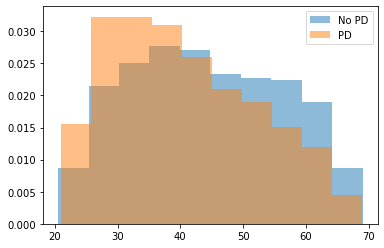

In [36]:
plt.hist(-x_train.DAYS_BIRTH[y_train==0]/365, density=True, alpha=0.5, label='No PD')
plt.hist(-x_train.DAYS_BIRTH[y_train==1]/365, density=True, alpha=0.5, label='PD')
plt.legend()

0.5502203093420042


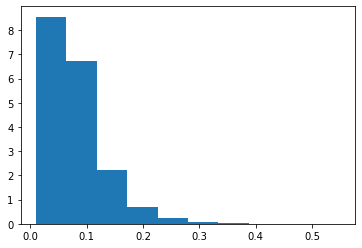

In [37]:
gbc_probas = gbc.predict_proba(x_valid_pp)[:,1]
plt.hist(gbc_probas, density=True);
print(max(gbc_probas))

(array([ 9940., 22070., 26001., 26742., 27603., 32191., 33409., 30702.,
        26435., 10915.]),
 array([-25201. , -23429.8, -21658.6, -19887.4, -18116.2, -16345. ,
        -14573.8, -12802.6, -11031.4,  -9260.2,  -7489. ]),
 <BarContainer object of 10 artists>)

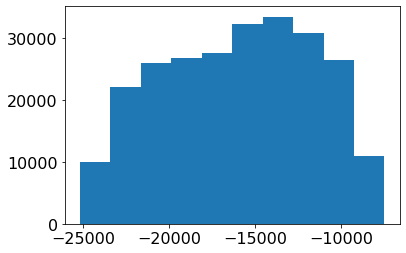

In [91]:
plt.hist(x_train.DAYS_BIRTH)

# Baseline Logistic Regression Model

press t to train, press l to load:  t


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Trained in 7s
Model score: 0.9192546583850931


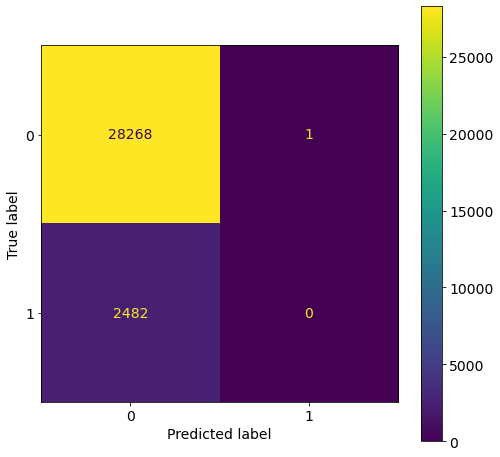

In [69]:
if input('press t to train, press l to load:  ')=='t':
    start = time.time()
    lm = LogisticRegression(random_state=17, class_weight=None, warm_start=True, max_iter=100, C=100)
    lm.fit(x_train_pp, y_train)
    end = time.time()

    save_model(lm, 'lm')
    print(f'Model Trained in {end-start:.0f}s')
    
    score = lm.score(x_valid_pp, y_valid)
    print(f'Model score: {score}')
    
else:
    model_name = input('model_name (no path or ext.):  ')
    lm = load('models/'+ model_name + '.joblib')
    
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(lm, x_valid_pp, y_valid, ax=ax1);

press t to train, press l to load:  l
model_name (no path or ext.):  lm_balanced10-27-2021-14-06-02


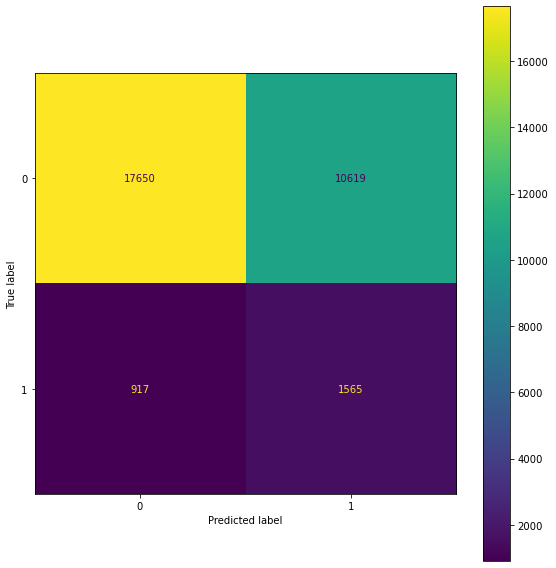

In [22]:
# Balanced logistic regression
if input('press t to train, press l to load:  ')=='t':
    start = time.time()
    lm_balanced = LogisticRegression(random_state=17, class_weight='balanced', warm_start=True, max_iter=100)
    lm_balanced.fit(x_train_pp, y_train)
    end = time.time()

    save_model(lm_balanced, 'lm_balanced')
    print(f'Model Trained in {end-start:.0f}s')
    
    score = lm_balanced.score(x_valid_pp, y_valid)
    print(f'Model score: {score}')

else:
    model_name = input('model_name (no path or ext.):  ')
    lm_balanced = load('models/'+ model_name + '.joblib')
    
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(lm_balanced, x_valid_pp, y_valid, ax=ax1);
plt.tight_layout()
# plt.savefig('baseline_confusion_matrix.png', dpi=300, facecolor='white', edgecolor='none');

# Random Forest Classifier

press t to train, press l to load:  t
Model Trained in 15s
Model score: 0.9192871776527592


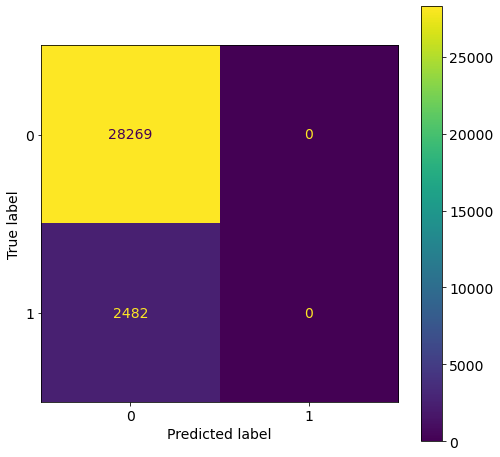

In [80]:
if input('press t to train, press l to load:  ')=='t':
    start=time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=3)
    rf.fit(x_train_pp, y_train)
    end = time.time()

    save_model(rf, 'rf')
    print(f'Model Trained in {end-start:.0f}s')
    
    score = rf.score(x_valid_pp, y_valid)
    print(f'Model score: {score}')
    
else:
    model_name = input('model_name (no path or ext.):  ')
    rf = load('models/'+ model_name + '.joblib')

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(rf, x_valid_pp, y_valid, ax=ax1);

# Gradient Boosted Forest Classifier

press t to train, press l to load:  t
Model Trained in 199s
Model score: 0.9192871776527592


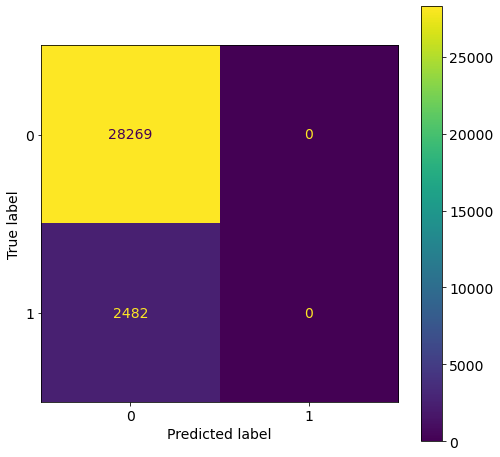

In [79]:
if input('press t to train, press l to load:  ')=='t':
    start=time.time()
    gbc = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, max_features=None
    )
    gbc.fit(x_train_pp, y_train)
    end = time.time()

    save_model(gbc, 'gbc')
    print(f'Model Trained in {end-start:.0f}s')
    
    score = gbc.score(x_valid_pp, y_valid)
    print(f'Model score: {score}')
    
else:
    model_name = input('model_name (no path or ext.):  ')
    gbc = load('models/'+ model_name + '.joblib')

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(gbc, x_valid_pp, y_valid, ax=ax1);

In [117]:
1078/(1078+1404)

0.43432715551974216

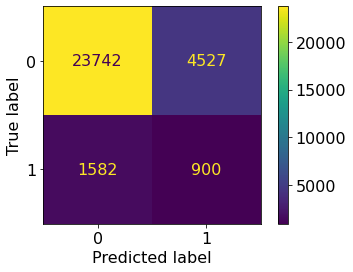

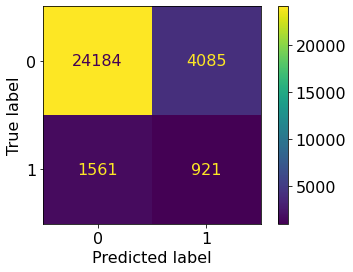

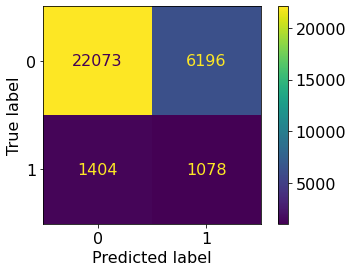

In [115]:
for i in range(len(models)):
    if i==2:
        ConfusionMatrixDisplay.from_predictions(y_valid, [1 if x >0.0909 else 0 for x in y_probas_[i]])
        plt.show();
    else:
        ConfusionMatrixDisplay.from_predictions(y_valid, [1 if x >0.1212 else 0 for x in y_probas_[i]])
        plt.show();

# Optimized Logistic Regression

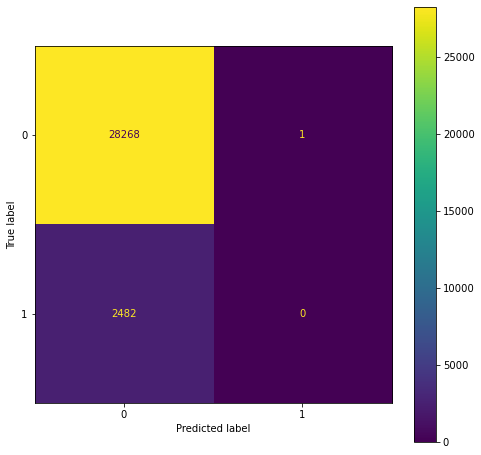

In [24]:
lm_grid = load('models/lm_grid10-27-2021-15-39-40.joblib')
lm_grid_best = lm_grid.best_estimator_

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(lm_grid_best, x_valid_pp, y_valid, ax=ax1);

# Ensemble

In [45]:
lm_grid_best.get_params()

{'C': 100.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
# rf = RandomForestClassifier(max_features='sqrt', random_state=17, n_jobs=-1)
# lm_e = LogisticRegression(random_state=17)

# eclf = VotingClassifier(
#     estimators=[('lm', lm_e), ('rf', rf)],
#     voting='soft'
# )

# params = {'rf__n_estimators': [20, 50, 100]}

# ens_grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
# ens_grid = ens_grid.fit(x_train_pp, y_train)
# eclf_best = ens_grid.best_estimator_

eclf_best.score(x_valid_pp, y_valid)
# save_model(ens_grid, 'ens_grid')

In [66]:
eclf_best.estimators_[0]

LogisticRegression(random_state=17)

(0.0, 1.0)

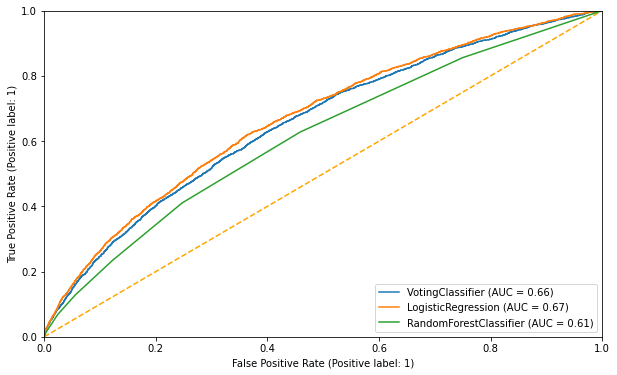

In [70]:
fig = plt.figure(figsize=(10,6))
ax = fig.subplots()
ax.plot([0,1], [0,1], linestyle='--', c='orange')

RocCurveDisplay.from_estimator(eclf_best, x_valid_pp, y_valid, ax=ax);
RocCurveDisplay.from_estimator(eclf_best.estimators_[0], x_valid_pp, y_valid, ax=ax);
RocCurveDisplay.from_estimator(eclf_best.estimators_[1], x_valid_pp, y_valid, ax=ax);
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# Evaluate and Compare Models

In [84]:
models = [lm, gbc, rf]
lm.name = 'LR'
# lm_balanced.name = 'LR (balanced weight)'
gbc.name = 'GBC'
# lm_grid_best.name = 'LR Optimized'
rf.name = 'RF'

y_probas_ = [model.predict_proba(x_valid_pp)[:,1] for model in models]
# y_score_ = [model.decision_function(x_valid_pp) for model in models]

fpr_, tpr_, thresholds_ = [], [], []
precision_, recall_, thresholds2_ = [], [], []
for i in range(len(models)):
    fpr_temp, tpr_temp, thresholds_temp = roc_curve(y_valid, y_probas_[i])
    fpr_.append(fpr_temp), tpr_.append(tpr_temp), thresholds_.append(thresholds_temp)
    
    precision_temp, recall_temp, thresholds2_temp = precision_recall_curve(y_valid, y_probas_[i])
    precision_.append(precision_temp), recall_.append(recall_temp), thresholds2_.append(thresholds2_temp)
    
roc_auc_ = [auc(fpr_[i], tpr_[i]) for i in range(len(models))]

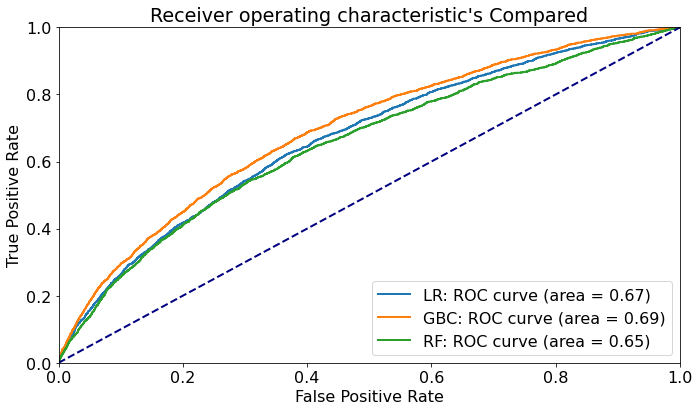

In [86]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})
lw = 2

for i, model in enumerate(models):
    plt.plot(fpr_[i], tpr_[i], lw=lw, 
             label='{}: ROC curve (area = {:.2f})'.format(model.name, roc_auc_[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver operating characteristic's Compared")
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('roc_curves.png', dpi=300, facecolor='white');

In [112]:
t_i = []
for i in range(len(thresholds2_)):
    if i==2:
        t_i.append(np.argmin([abs(x-0.0909) for x in thresholds2_[i]]))
    else:
        t_i.append(np.argmin([abs(x-0.1212) for x in thresholds2_[i]]))

In [113]:
print(thresholds2_[2][t_i[2]])

0.09090012213922515


In [114]:
for i, model in enumerate(models):
    print(f'{model.name} precision: {precision_[i][t_i[i]]:.3f}')
    print(f'{model.name} recall: {recall_[i][t_i[i]]:.3f}')

LR precision: 0.166
LR recall: 0.363
GBC precision: 0.184
GBC recall: 0.371
RF precision: 0.148
RF recall: 0.434


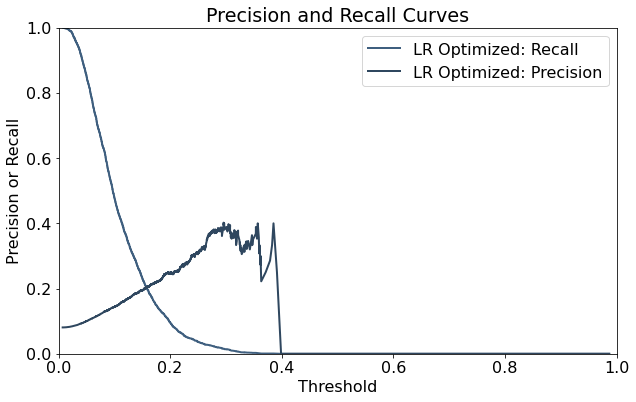

In [43]:
fig = plt.figure(figsize=(10,6))

c1 = ['#' + str(hex((int(255*(x+1)/(len(models)+1)))*256**2 +
                    (int(255*((x+1.5)%len(models))/(len(models)+1)))*256 + 
                    (int(255*((x+2)%len(models))/(len(models)+1)))))[2:] for x in range(len(models))]*len(models)

c2 = ['#' + str(hex((int(0.75*255*(x+1)/(len(models)+1)))*256**2 +
                    (int(0.75*255*((x+1.5)%len(models))/(len(models)+1)))*256 + 
                    (int(0.75*255*((x+2)%len(models))/(len(models)+1)))))[2:] for x in range(len(models))]*len(models)

for i, model in enumerate([models[2]]):
    plt.plot(thresholds2_[i], recall_[i][:-1], lw=lw, 
             label='{}: Recall'.format(model.name), c = c1[i])
    plt.plot(thresholds2_[i], precision_[i][:-1], lw=lw, 
             label='{}: Precision'.format(model.name), c = c2[i])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Threshold')
plt.ylabel('Precision or Recall')
plt.title('Precision and Recall Curves')
plt.legend()
plt.show()

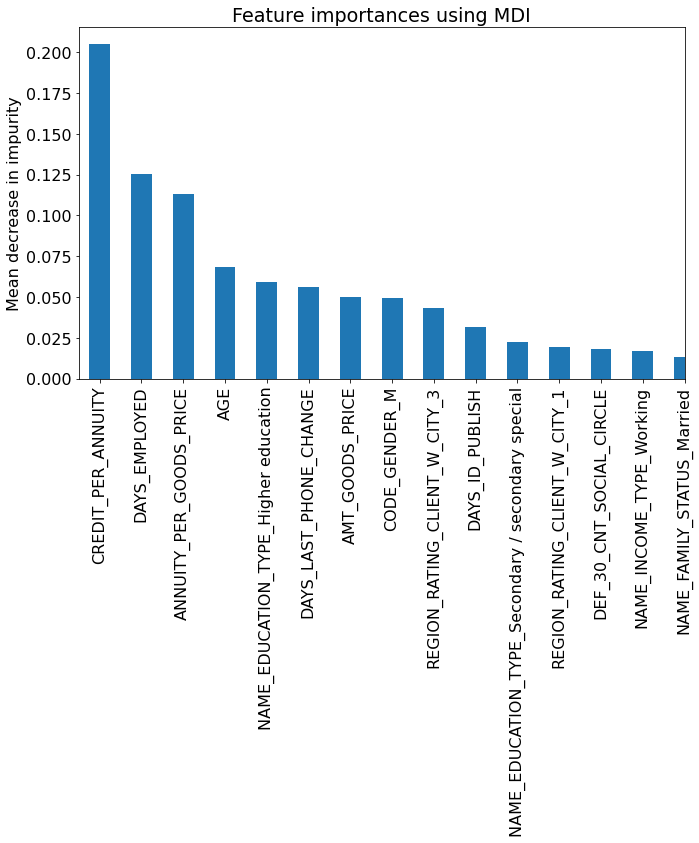

In [120]:
importances = gbc.feature_importances_
forest_importances = pd.Series(importances, index=feat_names).sort_values(ascending=False)

fig = plt.figure(figsize=(10,12))
ax = fig.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlim(right=14)
fig.tight_layout()

/tmp/ipykernel_19145/3099195769.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=x)


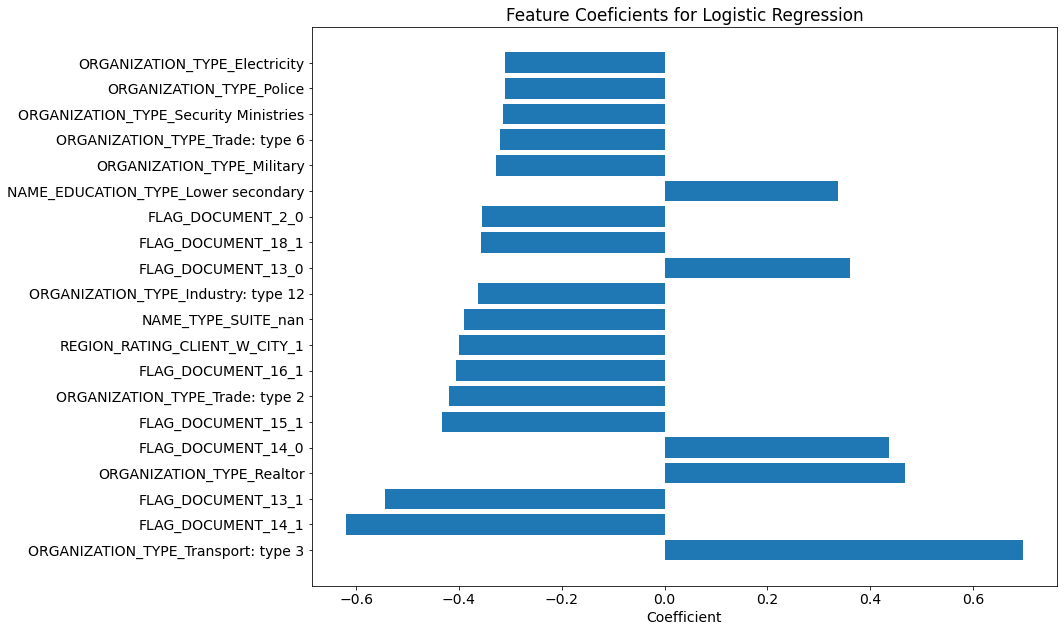

In [70]:
lm_coefs_sorted = pd.DataFrame(zip(feat_names, lm.coef_[0]))
lm_coefs_sorted.columns = ['feature', 'coef']
lm_coefs_sorted.sort_values(by='coef', axis=0, inplace=True, ascending=False, key=abs)

N=20
widths = lm_coefs_sorted.iloc[:N].coef
x = lm_coefs_sorted.iloc[:N].feature

fig = plt.figure(figsize=(15,9))
ax = fig.subplots()
ax.barh(y=x, width=widths)
ax.set_title("Feature Coeficients for Logistic Regression")
ax.set_xlabel("Coefficient")
ax.set_yticklabels(labels=x)
fig.tight_layout()

In [71]:
descriptions['OBS_30_CNT_SOCIAL_CIRCLE']

"How many observation of client's social surroundings with observable 30 DPD (days past due) default"

In [72]:
df['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [78]:
descriptions['REGION_RATING_CLIENT_W_CITY']

'Our rating of the region where client lives with taking city into account (1,2,3)'

In [77]:
# test = pd.DataFrame(zip(lm_coefs_sorted.feature, forest_importances.index))

# test.columns = ['LR', 'GBC']
# print(set(lm_coefs_sorted.feature.iloc[:20]).intersection(set(forest_importances.index[:20])))
# print(len(set(lm_coefs_sorted.feature.iloc[:20]).intersection(set(forest_importances.index[:20]))))

# test.head(20)
pd.options.display.max_rows=500
lm_coefs_sorted

,feature,coef
213,ORGANIZATION_TYPE_Transport: type 3,0.697361
36,FLAG_DOCUMENT_14_1,-0.620430
22,FLAG_DOCUMENT_13_1,-0.543671
195,ORGANIZATION_TYPE_Realtor,0.466930
35,FLAG_DOCUMENT_14_0,0.437329
38,FLAG_DOCUMENT_15_1,-0.433024
205,ORGANIZATION_TYPE_Trade: type 2,-0.419187
40,FLAG_DOCUMENT_16_1,-0.404744
92,REGION_RATING_CLIENT_W_CITY_1,-0.399328
119,NAME_TYPE_SUITE_nan,-0.389327


In [74]:
best_nums = ['DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AGE',
            'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_ID_PUBLISH']
lm_coefs_sorted[lm_coefs_sorted.feature.isin(num_feats)]

,feature,coef
13,DAYS_EMPLOYED,-0.194542
11,DAYS_LAST_PHONE_CHANGE,0.167256
15,AGE,-0.153211
18,ANNUITY_PER_GOODS_PRICE,-0.118483
12,DAYS_ID_PUBLISH,0.106213
3,DEF_30_CNT_SOCIAL_CIRCLE,0.090826
9,AMT_GOODS_PRICE,-0.085163
17,CREDIT_PER_ANNUITY,-0.074254
14,DAYS_REGISTRATION,0.060397
7,AMT_REQ_CREDIT_BUREAU_YEAR,0.058680


In [192]:
train_data_pp['ORGANIZATION_TYPE_Transport: type 3'].value_counts(normalize=True)

0.0    0.996146
1.0    0.003854
Name: ORGANIZATION_TYPE_Transport: type 3, dtype: float64

In [194]:
train_data_pp[train_data_pp.TARGET==1]['ORGANIZATION_TYPE_Transport: type 3'].value_counts(normalize=True)

0.0    0.996107
1.0    0.003893
Name: ORGANIZATION_TYPE_Transport: type 3, dtype: float64

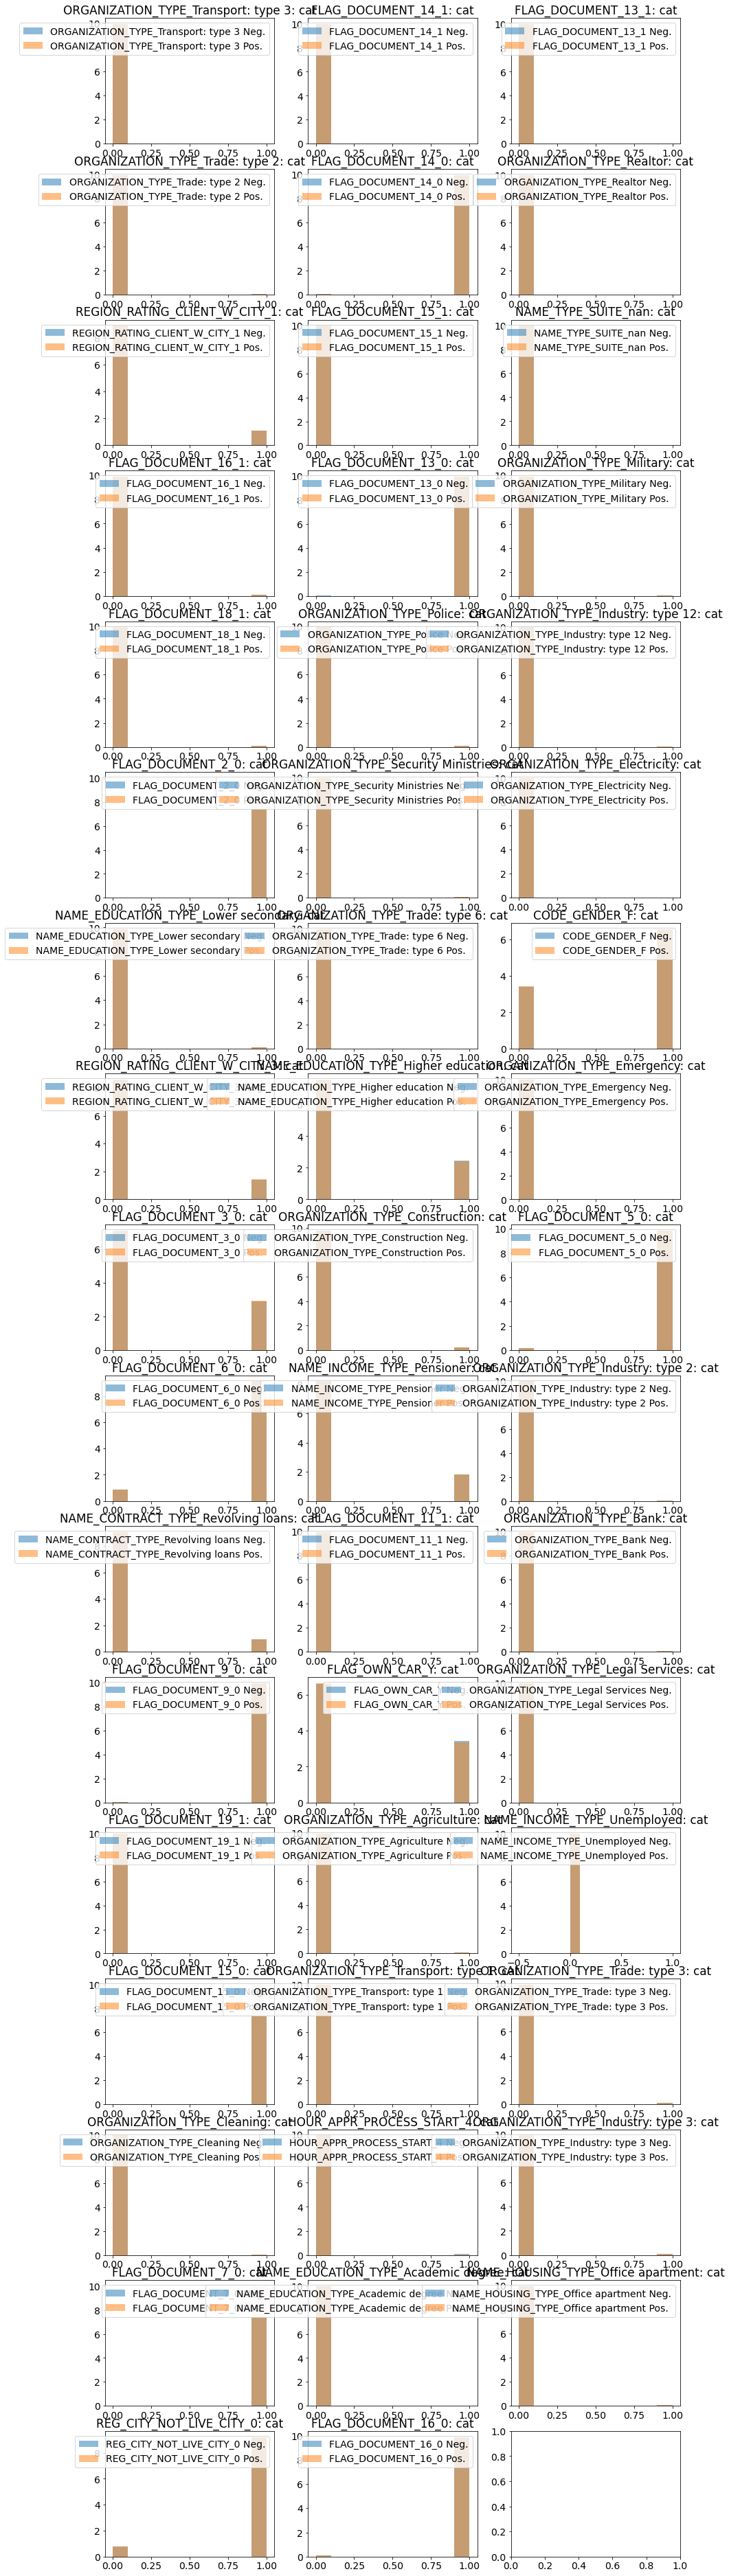

In [195]:
plot_features(lm_coefs_sorted.feature.iloc[:50])

In [181]:
def plot_features(feats: list):
    
    x = train_data_pp[feats]
    y = train_data_pp.TARGET
    
#     # only include features that are in x_train (remove categorical feats)
#     feats = set(feats)
#     feats = feats.intersection(set(x_train.columns))
    
    N = len(feats)
    feat_types = []
    for feat in feats:
        if feat in num_feats:
            feat_types.append('num')
        elif (feat in cat_feats_out) or (feat in cat_feats):
            feat_types.append('cat')
    
    fig = plt.figure(figsize=(15,4*(((N-1)//3)+1))) # gets taller every 2 add. features
    
    if N==1:
        ax = fig.subplots()
        ax.hist(x[y==0], density=True, alpha=0.5, label=feats[0]+' Neg.')
        ax.hist(x[y==1], density=True, alpha=0.5, label=feats[0]+' Pos.')
        ax.legend()
        ax.set_title(feats[0])
        
    else:
        axs = fig.subplots(nrows=(N-1)//3+1, ncols=3).flatten()
    
        for i, feat in enumerate(feats):
            axs[i].hist(x[y==0][feat], density=True, alpha=0.5, label=feat+' Neg.')
            axs[i].hist(x[y==1][feat], density=True, alpha=0.5, label=feat+' Pos.')
            axs[i].legend()
            axs[i].set_title(feat+': '+feat_types[i])

# Hyper Parameter Tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=0.1; total time=   9.0s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=0.1; total time=   8.7s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=0.1; total time=   8.6s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=0.1; total time=   8.3s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=0.1; total time=   8.0s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=1.0; total time=   8.2s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=1.0; total time=   8.1s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=1.0; total time=   8.0s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=1.0; total time=   8.2s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=1.0; total time=   9.3s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .............................................C=10.0; total time=   8.6s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .............................................C=10.0; total time=   8.5s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .............................................C=10.0; total time=   8.6s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .............................................C=10.0; total time=   8.8s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .............................................C=10.0; total time=   8.7s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................................C=100.0; total time=   8.4s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................................C=100.0; total time=   8.6s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................................C=100.0; total time=   8.9s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................................C=100.0; total time=   9.1s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................................C=100.0; total time=   9.2s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................................C=1000.0; total time=   9.3s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................................C=1000.0; total time=   8.6s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................................C=1000.0; total time=   8.0s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................................C=1000.0; total time=  12.8s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................................C=1000.0; total time=   8.5s


/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
{'C': 100.0}
0.0003019880924980407


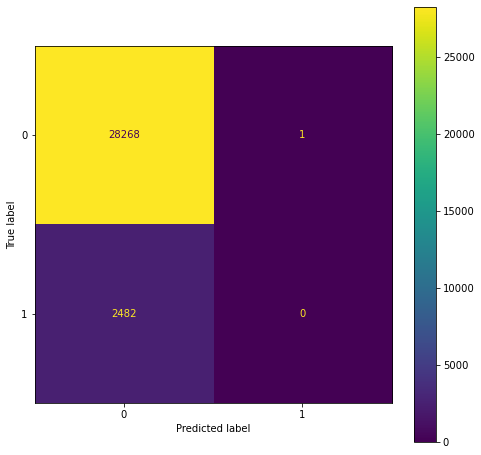

In [26]:
# parameters = {'C':np.logspace(-1, 3, 5)}
# lm_ = LogisticRegression()
# lm_grid = GridSearchCV(lm_, parameters, verbose=2, scoring='f1')
# lm_grid.fit(x_train_pp, y_train)

print(sorted(lm_grid.cv_results_.keys()))

# save_model(lm_grid, 'lm_grid')
 
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(lm_grid.best_estimator_, x_valid_pp, y_valid, ax=ax1);
print(lm_grid.best_params_)
print(lm_grid.best_score_)

In [27]:
lm_grid_best = lm_grid.best_estimator_

In [41]:
y_probas_[2]

array([0.05386951, 0.13869314, 0.14548131, ..., 0.03539103, 0.02801949,
       0.03847163])

Max f1_score: 0.24602644583945504
Max threshold: 0.12121212121212122


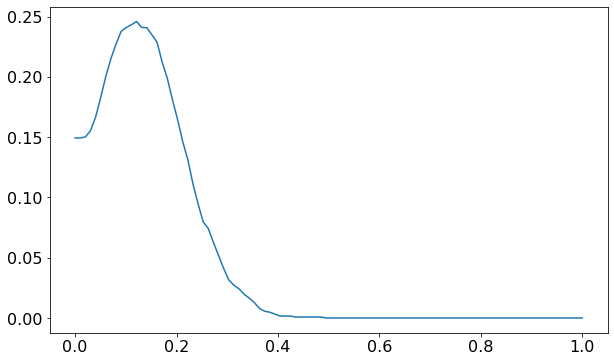

In [119]:
from sklearn.metrics import f1_score

t = np.linspace(0,1,100)

f1_scores = np.zeros(len(t))
for i in range(len(f1_scores)):
    f1_scores[i] = f1_score(y_true=y_valid, y_pred=[1 if x> t[i] else 0 for x in y_probas_[1]])

plt.figure(figsize=(10,6))
plt.plot(t, f1_scores)
print(f'Max f1_score: {np.max(f1_scores)}')
print(f'Max threshold: {t[np.argmax(f1_scores)]}')

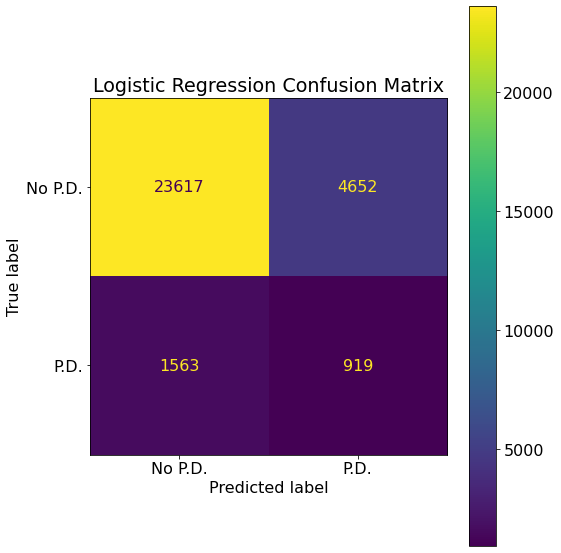

In [124]:
t = 0.12 #threshold
preds = [1 if x>t else 0 for x in y_probas_[0]]

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ConfusionMatrixDisplay.from_predictions(y_valid, preds, ax=ax1, display_labels=['No P.D.', 'P.D.']);
ax1.set_title('Logistic Regression Confusion Matrix')
plt.tight_layout()
# plt.savefig('lm_confusion_matrix.png', dpi=300)

In [40]:
print(f'Recall: {912/(912+1570):.3f}')
print(f'Precision: {912/(912+4640):.3f}')

Recall: 0.367
Precision: 0.164


In [41]:
print(f'{(1-0.164)/0.164:.1f}')

5.1


In [116]:
test = pd.DataFrame({1:['a', 'b', 'c'], 2:['a', 'b', 'c'], 3:['a', 'b', 'c']})
test.iloc[0]

1    a
2    a
3    a
Name: 0, dtype: object

In [174]:
lm_grid = load('models/lm_grid10-27-2021-15-39-40.joblib')
lm_grid_best = lm_grid.best_estimator_

In [194]:
def annotated_predict(est, x, threshold=0.12, n_reasons=5):
    
    x = np.array(x.todense())[0]
    proba = est.predict_proba(x.reshape(1,-1))[0][1]
    
    ex_result = pd.DataFrame({'normalized_feat_value': x , 'impact_on_pred' : est.coef_[0] * x}, index=feat_names, )
    ex_result.sort_values('impact_on_pred', axis=0, ascending=True, inplace=True)
    
    if proba > threshold:
        print(f'Higher Risk Loan (probability of PD = {proba:.3f})\n')
        print(f'Top {n_reasons} reasons for denial and their normalized values:')
        print(ex_result[ex_result.index != 'CODE_GENDER_F'].iloc[:n_reasons].normalized_feat_value.to_markdown())
        
    if proba < threshold:
        print(f'APPROVE (probability of PD = {proba:.3f})\n')
        print(f'Top {n_reasons} reasons for approval and their normalized values:')
        print(ex_result.iloc[:-(n_reasons+1):-1].normalized_feat_value.to_markdown())

In [195]:
annotated_predict(lm, x_valid_pp[4])

Higher Risk Loan (probability of PD = 0.223)

Top 5 reasons for denial and their normalized values:
|                   |   normalized_feat_value |
|:------------------|------------------------:|
| FLAG_DOCUMENT_2_0 |                       1 |
| FLAG_DOCUMENT_5_0 |                       1 |
| FLAG_DOCUMENT_6_0 |                       1 |
| FLAG_DOCUMENT_9_0 |                       1 |
| FLAG_DOCUMENT_7_0 |                       1 |


# LR Feature Importance by Brute Force

In [26]:
# train a logistic regression model with all but one feature for each feature in the dataset
# then score the model and see how much the performance changed by removing the feature to 
# determine which was the most important features for model performance

feat_imp_df = pd.DataFrame(np.zeros(len(feat_names)), index=feat_names, columns=['delta_performance'])

# for i, feat in enumerate(num_feats):
#     x = np.concatenate((x_train_pp[:,:i], x_train_pp[:,i+1:]), axis=1)
#     x_v = np.concatenate((x_valid_pp[:,:i], x_valid_pp[:,i+1:]), axis=1)
    
#     lr_minus_one_feat = LogisticRegression(C=100, random_state=17)
#     lr_minus_one_feat.fit(x, y_train)
    
#     y_score_one_feat = lr_minus_one_feat.decision_function(x_v)
#     fpr_one_feat, tpr_one_feat, _ = roc_curve(y_valid, y_score_one_feat)
#     feat_imp_df.loc[feat] = auc(fpr_one_feat, tpr_one_feat)
    
# max_score = feat_imp_df['delta_performance'].max()
# feat_imp_df['delta_performance'] = feat_imp_df['delta_performance'].apply(lambda x: x - max_score)

/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/john/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [39]:
feat_imp_df.sort_values('delta_performance', ascending=False)[:22]

,delta_performance
AMT_REQ_CREDIT_BUREAU_WEEK,0.000000
OBS_30_CNT_SOCIAL_CIRCLE,-0.000151
CNT_CHILDREN,-0.000178
OBS_60_CNT_SOCIAL_CIRCLE,-0.000189
CNT_NON_CHILD_FAM_MEMBERS,-0.000190
AMT_REQ_CREDIT_BUREAU_MON,-0.000210
AMT_REQ_CREDIT_BUREAU_HOUR,-0.000236
REGION_POPULATION_RELATIVE,-0.000291
CREDIT_PER_ANNUITY,-0.000374
AMT_REQ_CREDIT_BUREAU_QRT,-0.000381


In [56]:
descriptions['DAYS_ID_PUBLISH']

'How many days before the application did client change the identity document with which he applied for the loan'

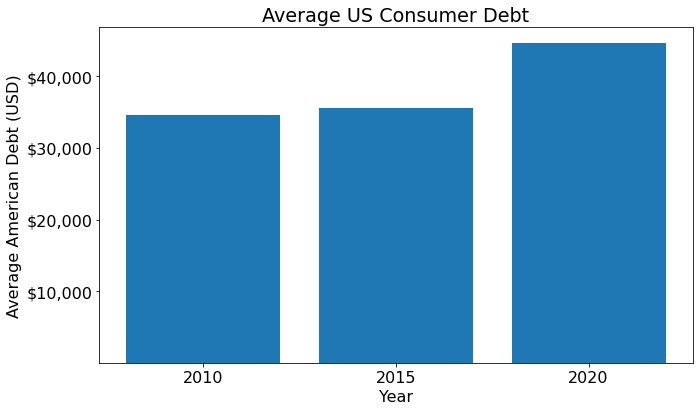

In [133]:
plt.figure(figsize=(10,6))
debt = np.array([11.52, 11.87, 14.88])
debt *= 1_000_000_000_000
debt /= 333564250
plt.bar(x=[1,2,3], height = debt)
plt.xlabel('Year')
plt.ylabel('Average American Debt (USD)')
plt.yticks(ticks = [10000, 20000, 30000, 40000], labels=['$10,000', '$20,000', '$30,000', '$40,000']);
plt.xticks(ticks = [1, 2, 3], labels = [2010, 2015, 2020]);
plt.title('Average US Consumer Debt')
plt.tight_layout()
plt.savefig('average_us_consumer_debt.png', dpi=300)